# auto_annot_Haber2017_with_Smillie2019_dblabel

In [1]:
import besca as bc
import pandas as pd
import pkg_resources

/pstore/home/hatjek/.conda/envs/besca_test/lib/python3.6/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


### Specify folders where .h5ad files are found and their names. 

The datasets that are already annotated and should be used for training. If you only use one dataset please use list of one.

In [2]:
# the path to the datasets
train_dataset_paths = [pkg_resources.resource_filename('besca', 'datasets/data')]
#the names of the h5ad files
train_datasets =['Smillie2019_processed.h5ad']

The dataset of interest that should be annotated.

In [3]:
test_dataset = 'haber_processed.h5ad'
test_dataset_path =  pkg_resources.resource_filename('besca', 'datasets/data')

Give your analysis a name.

In [4]:
analysis_name = 'auto_annot_Haber2017_with_Smillie2019_Cluster' 

### Now specify parameters

Specify column name of celltype annotation you want to train on.

In [5]:
celltype_train ='dblabel' 
celltype_test = 'dblabel'

Choose a method:

- linear: Support Vector Machine with Linear Kernel
- sgd: Support Vector Machine with Linear Kernel using Stochastic Gradient Descent
- rbf: Support Vector Machine with radial basis function kernel. Very time intensive, use only on small datasets.
- logistic_regression: Standard logistic classifier iwth multinomial loss.
- logistic_regression_ovr: Logistic Regression with one versus rest classification.
- logistic_regression_elastic: Logistic Regression with elastic loss, cross validates among multiple l1 ratios.

In [6]:
method = 'logistic_regression'

Specify merge method if using multiple training datasets. Needs to be either scanorama or naive.

In [7]:
merge = 'scanorama'

Decide if you want to use the raw format or highly variable genes. Raw increases computational time and does not necessarily improve predictions.

In [8]:
use_raw = False

You can choose to only consider a subset of genes from a signature set.

In [9]:
genes_to_use = 'all'

### Read in all training and the testing set.

In [10]:
adata_trains, adata_pred, adata_orig = bc.tl.auto_annot.read_data(train_paths = train_dataset_paths,train_datasets= train_datasets, test_path=  test_dataset_path, test_dataset= test_dataset, use_raw = use_raw)

Transforming to str index.


Reading files


Transforming to str index.


In [11]:
# Select epithelial subset from Smillie2019 dataset
epithelial_subset = bc.subset_adata(adata_trains[0], adata_trains[0].obs.celltype_highlevel == 'Epi', raw=False)
adata_trains[0] = epithelial_subset

In [12]:
# Convert mouse symbols (MGI) to human symbols (HGNC)
mousehuman_file = pkg_resources.resource_filename('besca', 'datasets/homologs/MGItoHGNC.csv')
mousehuman=pd.read_csv(mousehuman_file,sep='\t',header='infer', encoding="unicode_escape")
mousehuman.index=mousehuman['MGI']
conversion=pd.Series(data=mousehuman['HGNC'], index=mousehuman.index)

In [13]:
# Convert mouse symbols (MGI) to human symbols (HGNC)
adata_orig.var.rename(columns={'SYMBOL':'MGI'}, inplace=True)
adata_orig.var['SYMBOL'] = adata_orig.var['MGI'].map(lambda x: conversion.get(x, default='') if type(conversion.get(x, default='')) == str else conversion.get(x, default=None).values[0])
adata_orig.var.index = adata_orig.var.SYMBOL
adata_orig.var_names_make_unique()
adata_pred = adata_orig.copy()

This function merges training datasets, removes unwanted genes, and if scanorama is used corrects for datasets.

In [14]:
adata_train, adata_pred = bc.tl.auto_annot.merge_data(adata_trains, adata_pred, genes_to_use = genes_to_use, merge = merge)

merging with scanorama
using scanorama rn
Found 273 genes among all datasets
[[0.         0.73639414]
 [0.         0.        ]]
Processing datasets (0, 1)
integrating training set
calculating intersection


### Train the classifier.

The returned scaler is fitted on the training dataset (to zero mean and scaled to unit variance).

In [15]:
classifier, scaler = bc.tl.auto_annot.fit(adata_train, method, celltype_train)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  1.5min finished
/pstore/home/hatjek/.conda/envs/besca_test/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



### Prediction

Use fitted model to predict celltypes in adata_pred. Prediction will be added in a new column called 'auto_annot'. Paths are needed as adata_pred will revert to its original state (all genes, no additional corrections).
The threshold should be set to 0 or left out for SVM. For logisitic regression the threshold can be set.

In [21]:
adata_predicted = bc.tl.auto_annot.adata_predict(classifier = classifier, scaler = scaler, adata_pred = adata_pred, adata_orig = adata_orig, threshold = 0.7)

Write out metrics to a report file, create confusion matrices and comparative umap plots

In [22]:
adata_pred.obs

CELL  \
haber_intestine_donor_M1_Duo.AAACATACAGCGGA    haber_intestine_donor_M1_Duo.AAACATACAGCGGA   
haber_intestine_donor_M1_Duo.AAACATACCTTACT    haber_intestine_donor_M1_Duo.AAACATACCTTACT   
haber_intestine_donor_M1_Duo.AAACATACTTTGCT    haber_intestine_donor_M1_Duo.AAACATACTTTGCT   
haber_intestine_donor_M1_Duo.AAACCGTGCAGTCA    haber_intestine_donor_M1_Duo.AAACCGTGCAGTCA   
haber_intestine_donor_M1_Duo.AAACGCTGCAGTCA    haber_intestine_donor_M1_Duo.AAACGCTGCAGTCA   
haber_intestine_donor_M1_Duo.AAACGCTGCGTGAT    haber_intestine_donor_M1_Duo.AAACGCTGCGTGAT   
haber_intestine_donor_M1_Duo.AAACGCTGTCCAGA    haber_intestine_donor_M1_Duo.AAACGCTGTCCAGA   
haber_intestine_donor_M1_Duo.AAACGCTGTTCACT    haber_intestine_donor_M1_Duo.AAACGCTGTTCACT   
haber_intestine_donor_M1_Duo.AAACGGCTACACTG    haber_intestine_donor_M1_Duo.AAACGGCTACACTG   
haber_intestine_donor_M1_Duo.AAACGGCTCAACCA    haber_intestine_donor_M1_Duo.AAACGGCTCAACCA   
haber_intestine_donor_M1_Duo.AAACGGCTCTAAGC    haber_intestine_donor_M1_Duo.AAACGGCTCTAAGC   
haber_intestine_donor_M1_Duo.AAACGGCTGTTGCA    haber_intestine_donor_M1_Duo.AAACGGCTGTTGCA   
haber_intestine_donor_M1_Duo.AAAGACGAACGTTG    haber_intestine_donor_M1_Duo.AAAGACGAACGTTG   
haber_intestine_donor_M1_Duo.AAAGAGACGGCATT    haber_intestine_donor_M1_Duo.AAAGAGACGGCATT   
haber_intestine_donor_M1_Duo.AAAGCAGAGCGTTA    haber_intestine_donor_M1_Duo.AAAGCAGAGCGTTA   
haber_intestine_donor_M1_Duo.AAAGGCCTGAGGCA    haber_intestine_donor_M1_Duo.AAAGGCCTGAGGCA   
haber_intestine_donor_M1_Duo.AAAGGCCTGGAACG    haber_intestine_donor_M1_Duo.AAAGGCCTGGAACG   
haber_intestine_donor_M1_Duo.AAAGTTTGCCATAG    haber_intestine_donor_M1_Duo.AAAGTTTGCCATAG   
haber_intestine_donor_M1_Duo.AAATACTGCGTACA    haber_intestine_donor_M1_Duo.AAATACTGCGTACA   
haber_intestine_donor_M1_Duo.AAATACTGGGTGAG    haber_intestine_donor_M1_Duo.AAATACTGGGTGAG   
haber_intestine_donor_M1_Duo.AAATCCCTAAGCCT    haber_intestine_donor_M1_Duo.AAATCCCTAAGCCT   
haber_intestine_donor_M1_Duo.AAATCTGAACGGGA    haber_intestine_donor_M1_Duo.AAATCTGAACGGGA   
haber_intestine_donor_M1_Duo.AAATCTGACGGAGA    haber_intestine_donor_M1_Duo.AAATCTGACGGAGA   
haber_intestine_donor_M1_Duo.AAATTCGATCGTAG    haber_intestine_donor_M1_Duo.AAATTCGATCGTAG   
haber_intestine_donor_M1_Duo.AAATTCGATTATCC    haber_intestine_donor_M1_Duo.AAATTCGATTATCC   
haber_intestine_donor_M1_Duo.AAATTGACATCGTG    haber_intestine_donor_M1_Duo.AAATTGACATCGTG   
haber_intestine_donor_M1_Duo.AACAATACAGGCGA    haber_intestine_donor_M1_Duo.AACAATACAGGCGA   
haber_intestine_donor_M1_Duo.AACAATACCTGAAC    haber_intestine_donor_M1_Duo.AACAATACCTGAAC   
haber_intestine_donor_M1_Duo.AACACTCTCTGATG    haber_intestine_donor_M1_Duo.AACACTCTCTGATG   
haber_intestine_donor_M1_Duo.AACACTCTCTGTGA    haber_intestine_donor_M1_Duo.AACACTCTCTGTGA   
...                                                                                    ...   
haber_intestine_donor_M2_Il.TTCTGATGCTCTAT      haber_intestine_donor_M2_Il.TTCTGATGCTCTAT   
haber_intestine_donor_M2_Il.TTGAATGATGGTTG      haber_intestine_donor_M2_Il.TTGAATGATGGTTG   
haber_intestine_donor_M2_Il.TTGAGGACTGCTGA      haber_intestine_donor_M2_Il.TTGAGGACTGCTGA   
haber_intestine_donor_M2_Il.TTGAGGTGCTCCCA      haber_intestine_donor_M2_Il.TTGAGGTGCTCCCA   
haber_intestine_donor_M2_Il.TTGATCTGAGACTC      haber_intestine_donor_M2_Il.TTGATCTGAGACTC   
haber_intestine_donor_M2_Il.TTGCATTGGGTGAG_1  haber_intestine_donor_M2_Il.TTGCATTGGGTGAG_1   
haber_intestine_donor_M2_Il.TTGCTAACAAGGCG      haber_intestine_donor_M2_Il.TTGCTAACAAGGCG   
haber_intestine_donor_M2_Il.TTGCTAACGCCCTT      haber_intestine_donor_M2_Il.TTGCTAACGCCCTT   
haber_intestine_donor_M2_Il.TTGCTATGATGCCA      haber_intestine_donor_M2_Il.TTGCTATGATGCCA   
haber_intestine_donor_M2_Il.TTGCTATGCCTAAG      haber_intestine_donor_M2_Il.TTGCTATGCCTAAG   
haber_intestine_donor_M2_Il.TTGCTATGCCTGTC      haber_intestine_donor_M2_Il.TTGCTATGCCTGTC   
haber_intestine_donor_M2_Il.TTGCTATGTAGTCG  

/pstore/home/hatjek/.conda/envs/besca_test/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/pstore/home/hatjek/.conda/envs/besca_test/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

... storing 'auto_annot' as categorical


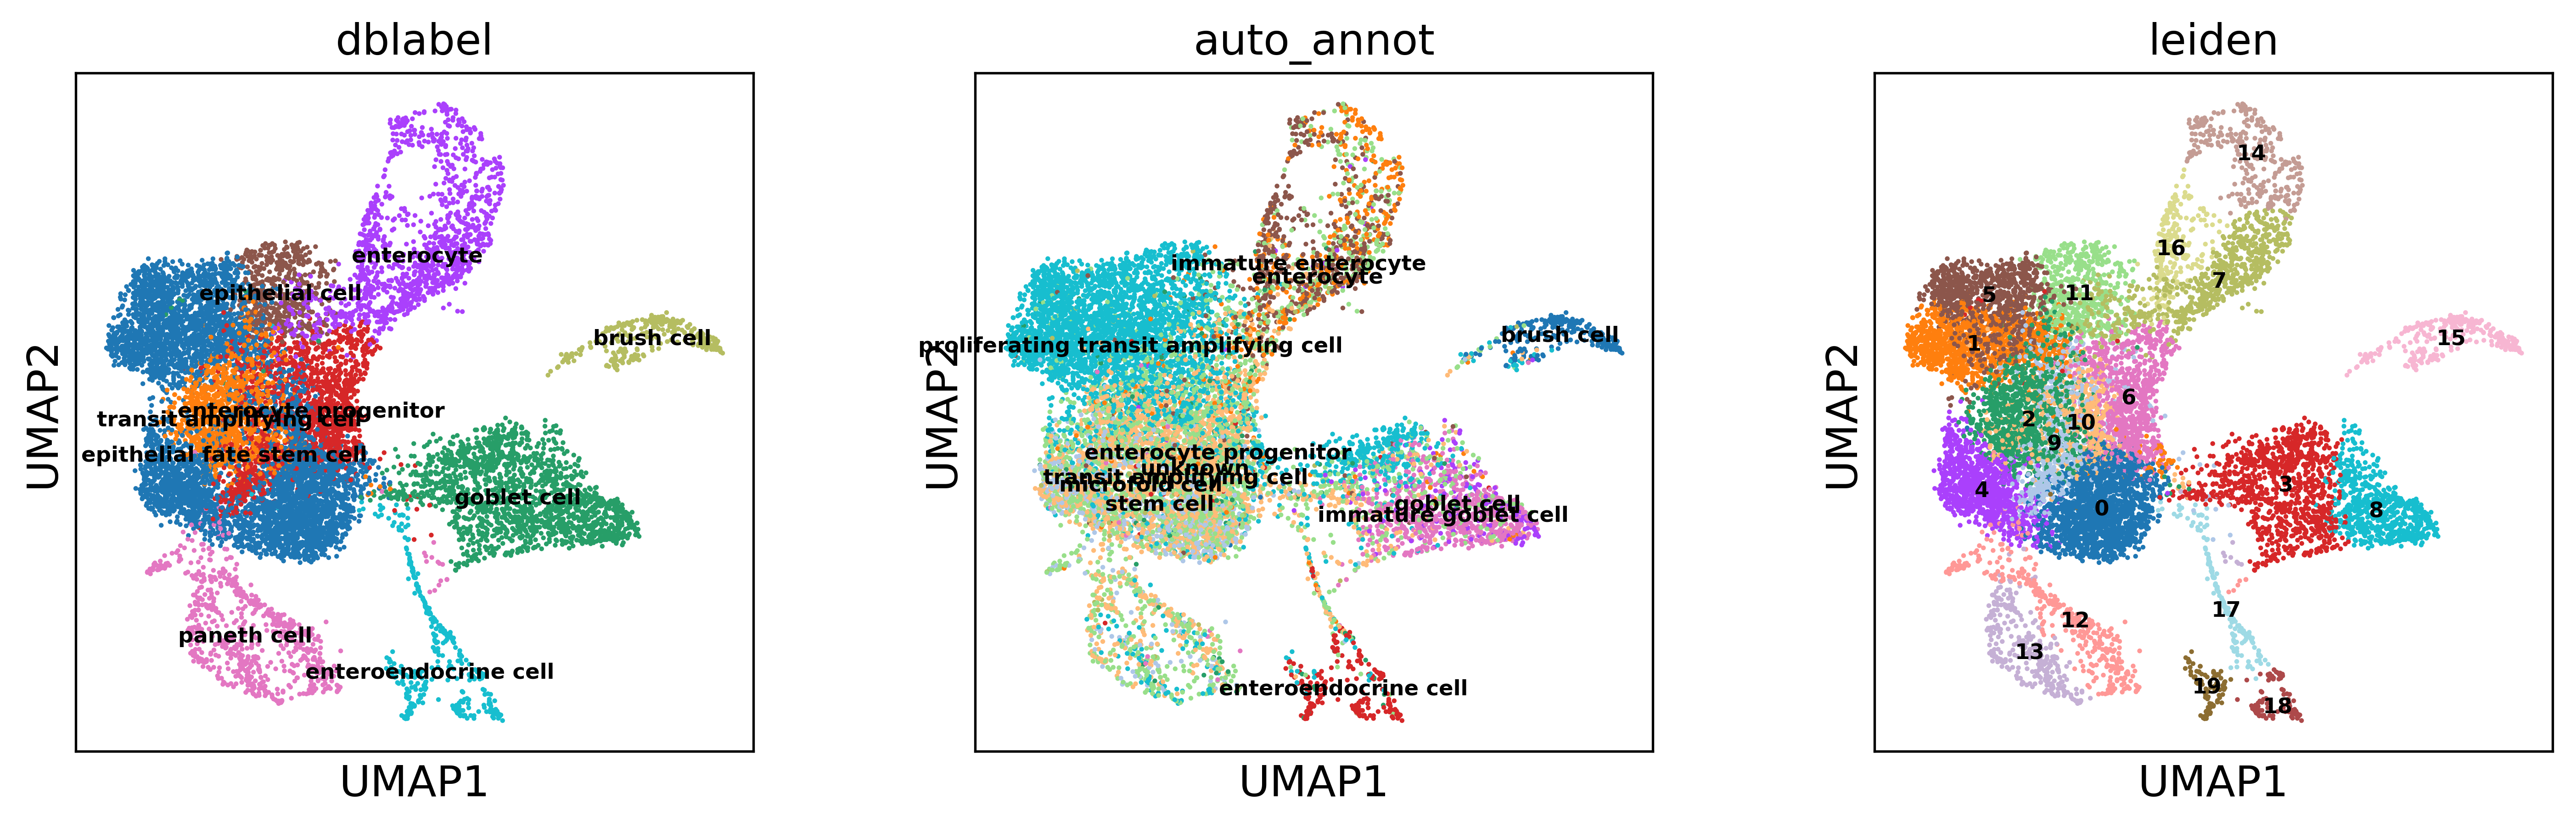

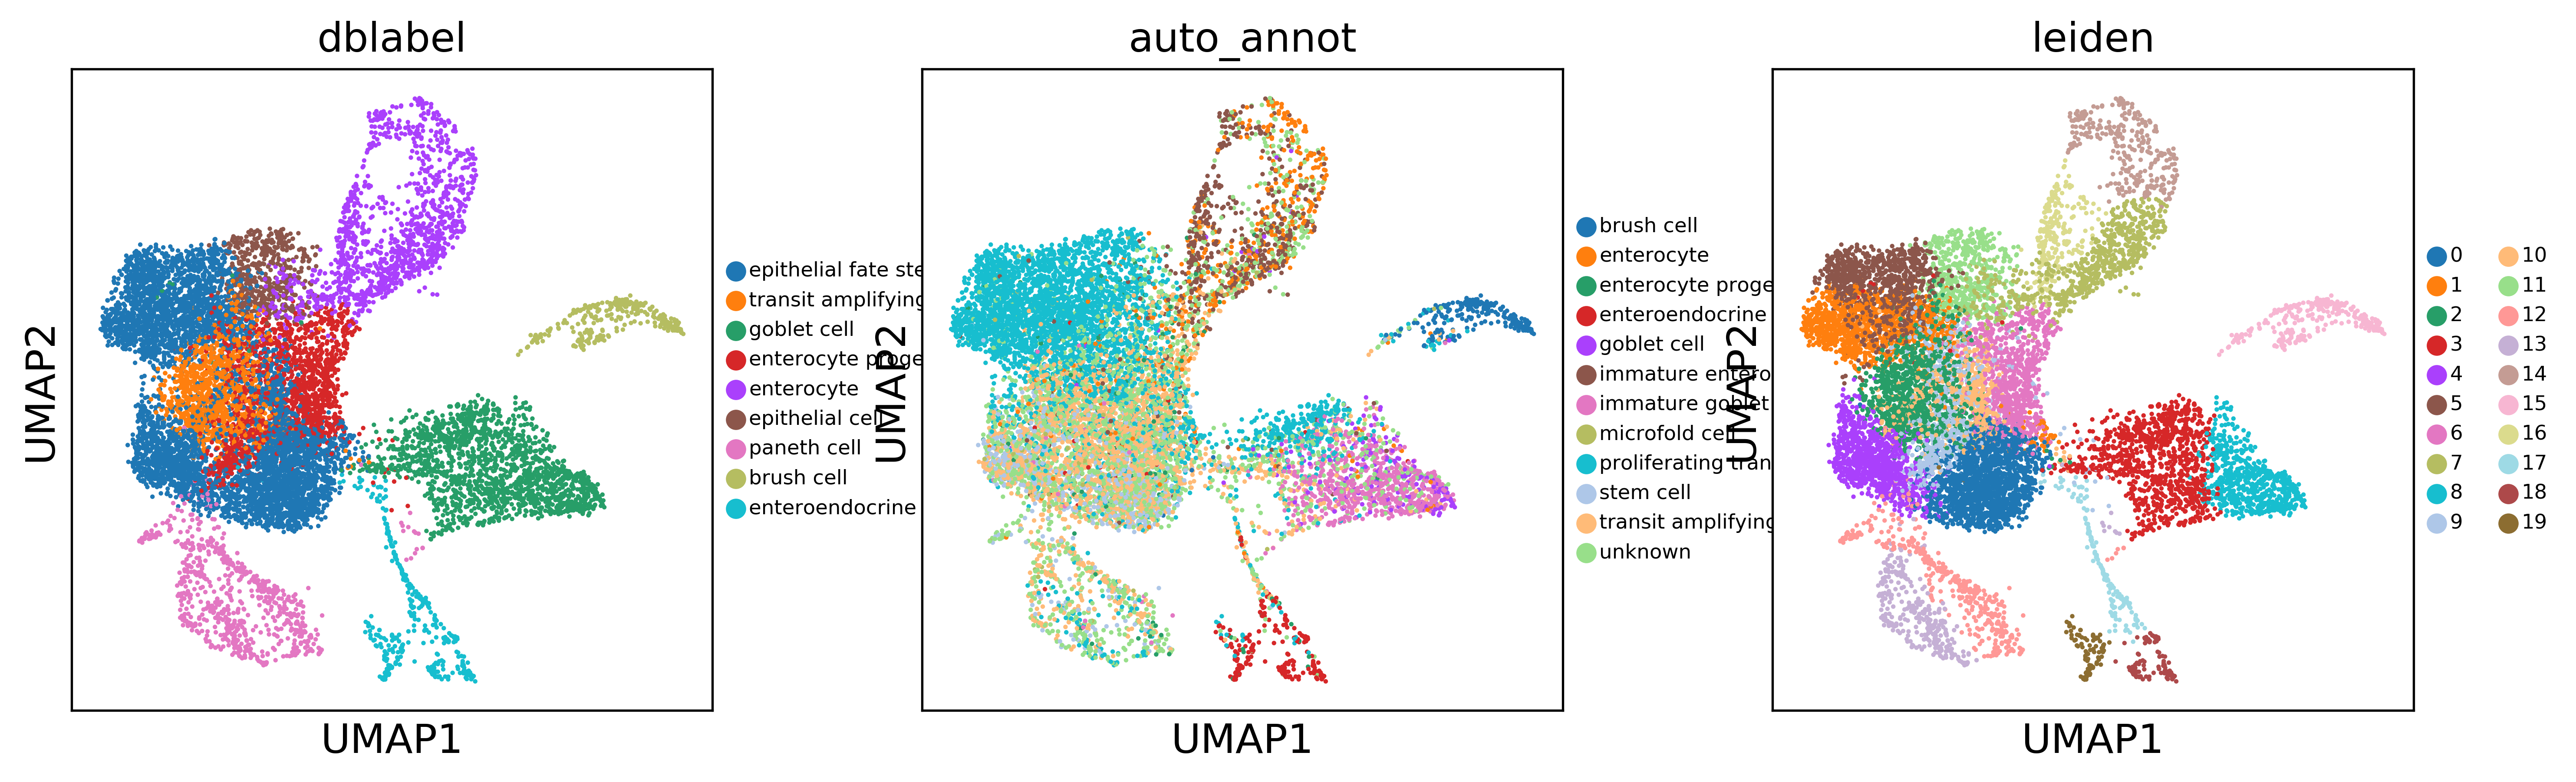

Confusion matrix, without normalization
Normalized confusion matrix


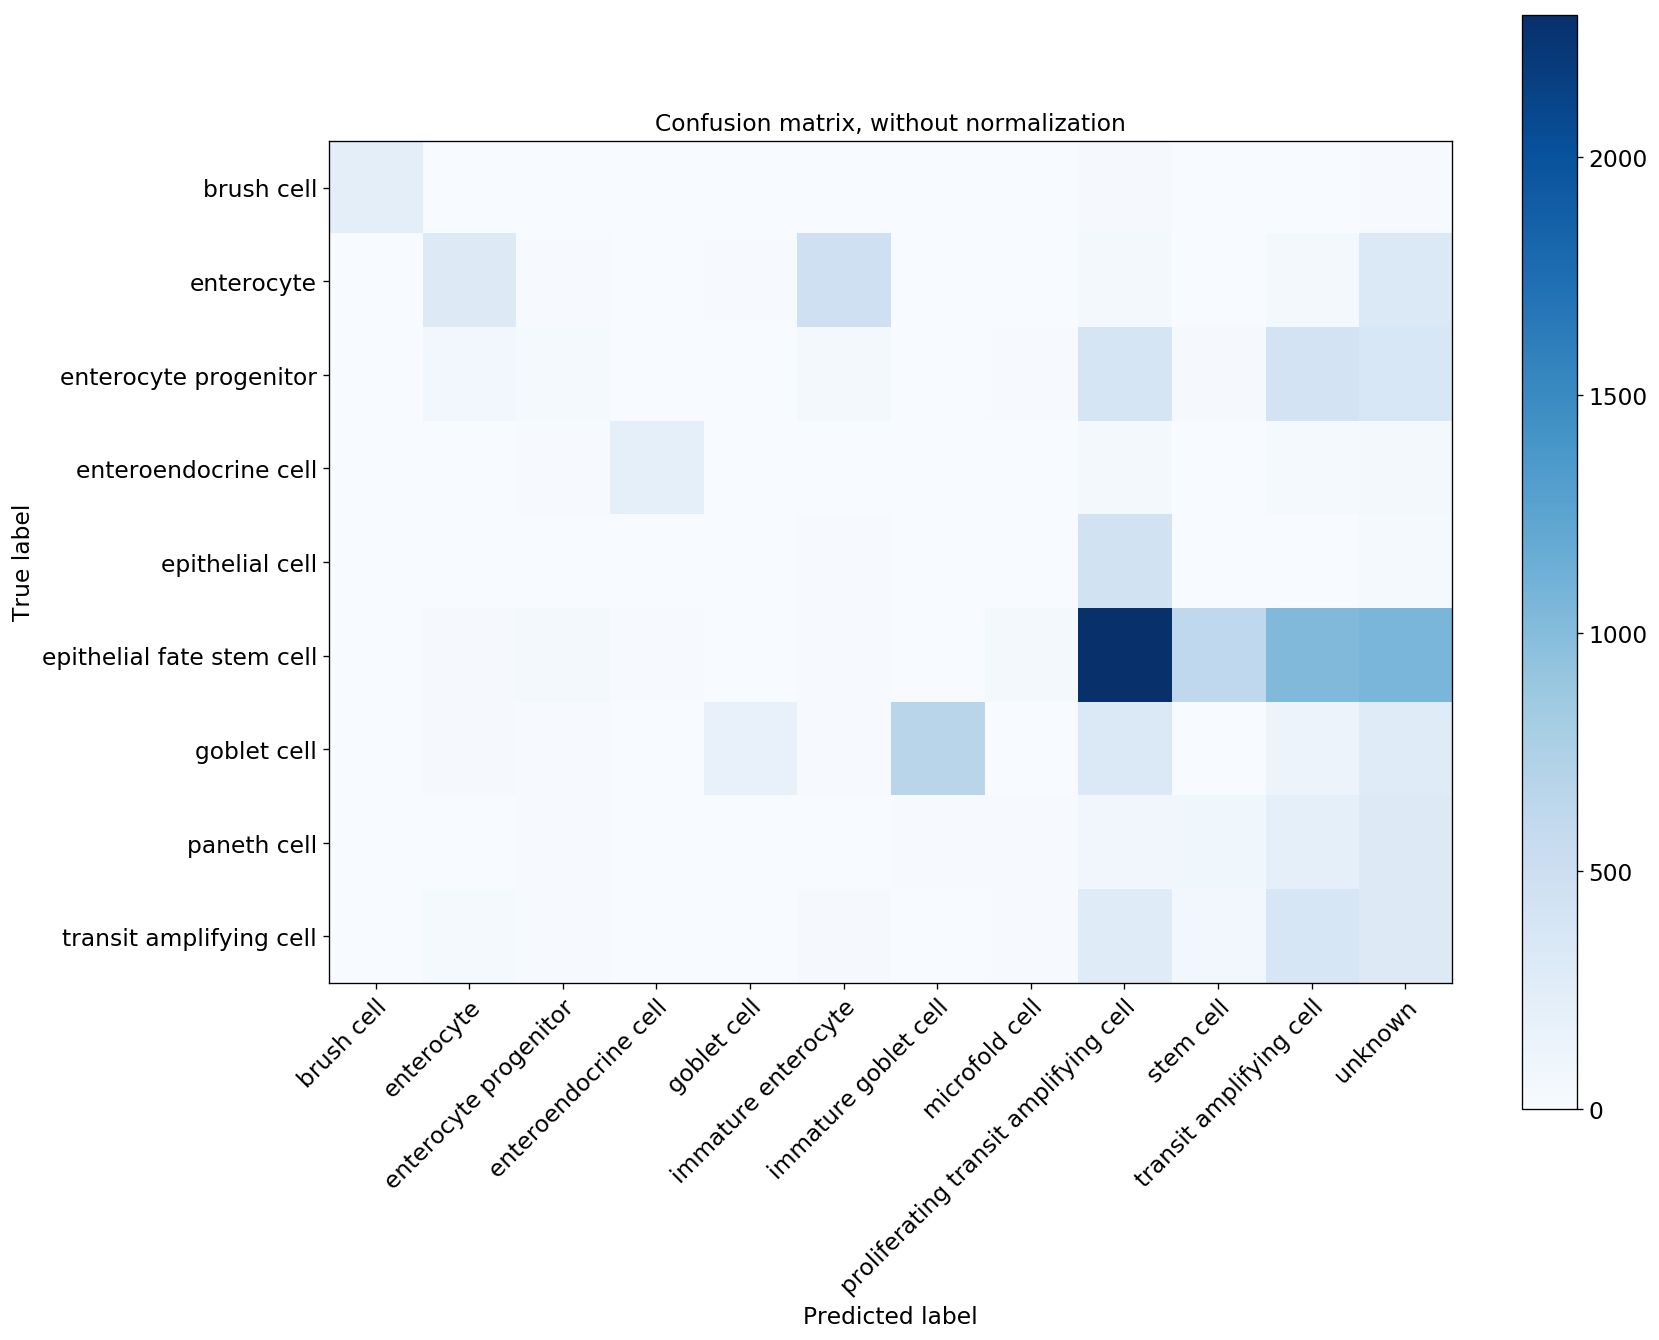

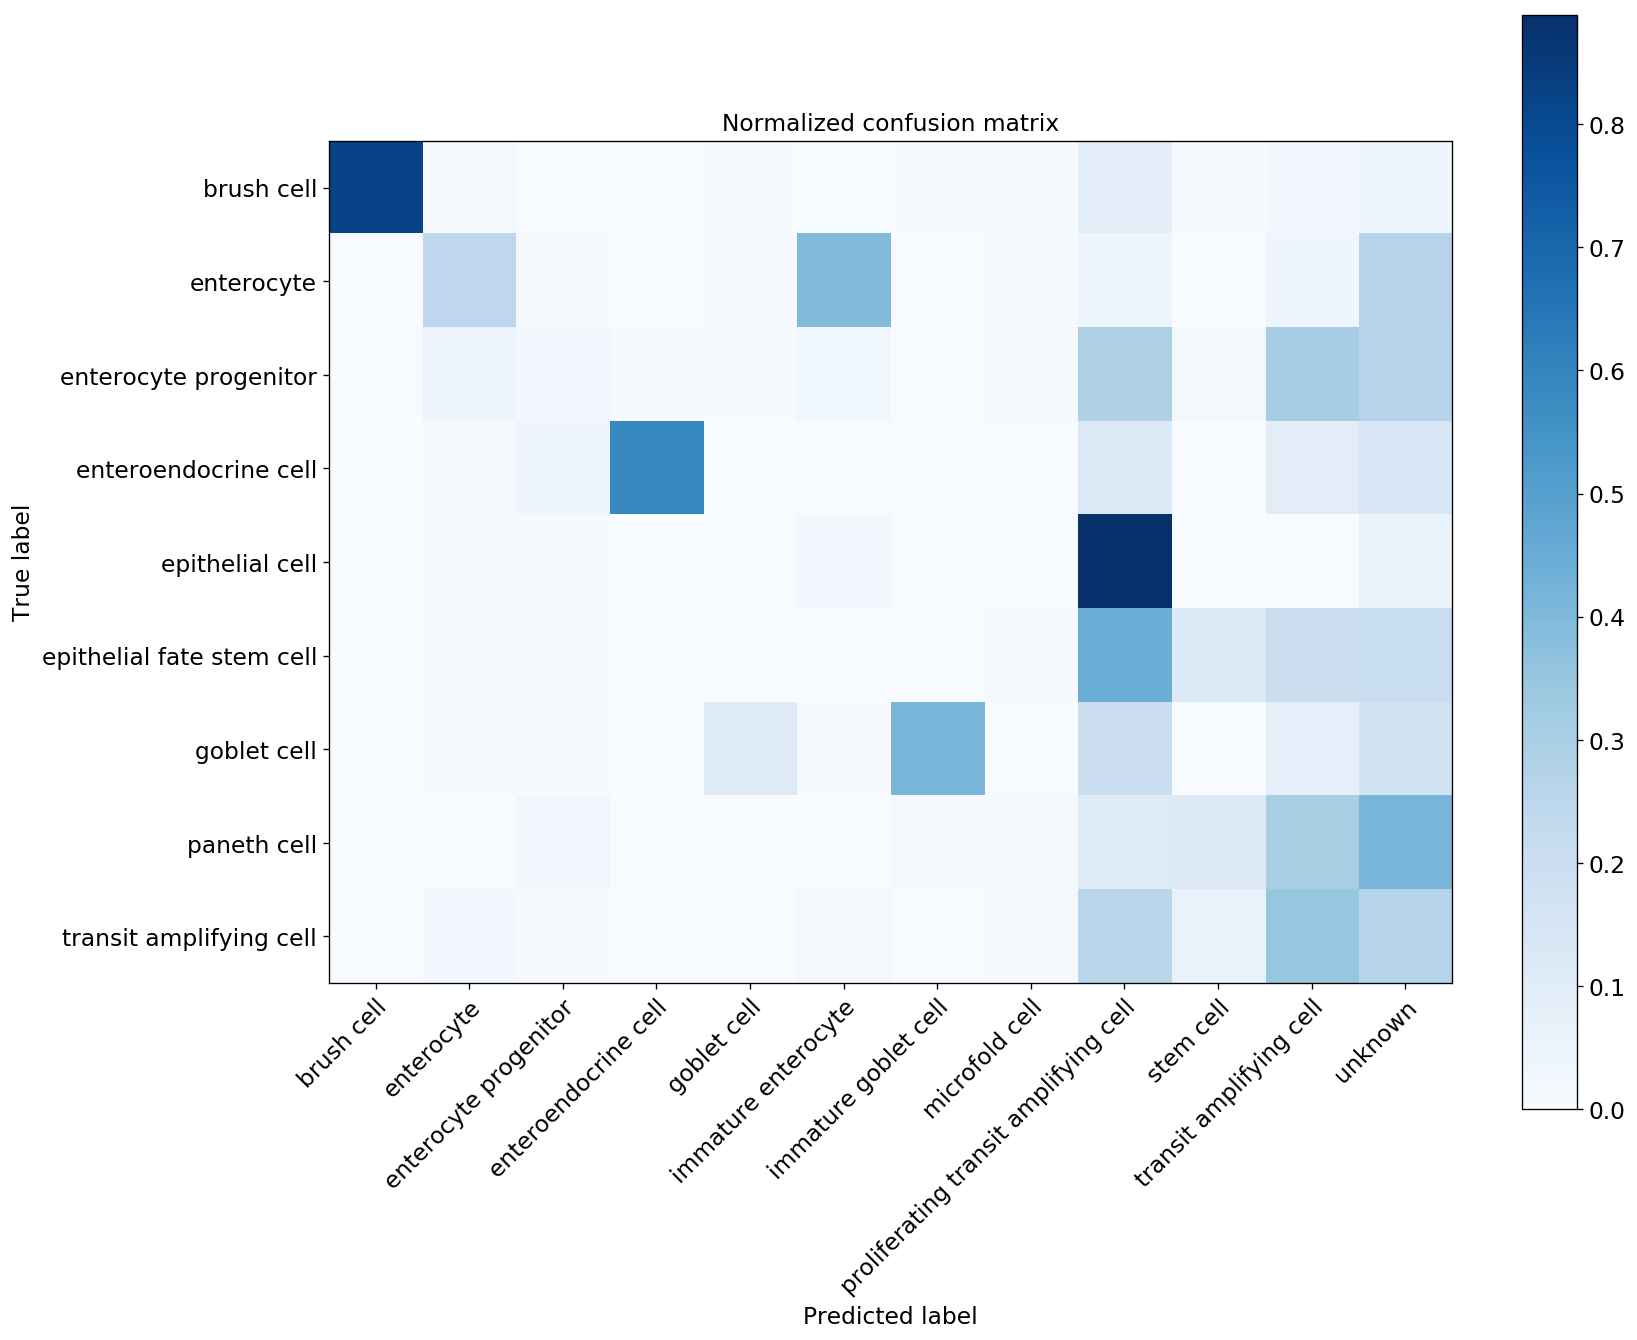

In [23]:
%matplotlib inline

bc.tl.auto_annot.report(adata_pred=adata_predicted, celltype=celltype_test, method=method, analysis_name=analysis_name,
                        train_datasets=train_datasets, test_dataset=test_dataset, merge=merge, use_raw=False,
                        genes_to_use=genes_to_use, remove_nonshared=True, clustering='leiden', asymmetric_matrix=True)

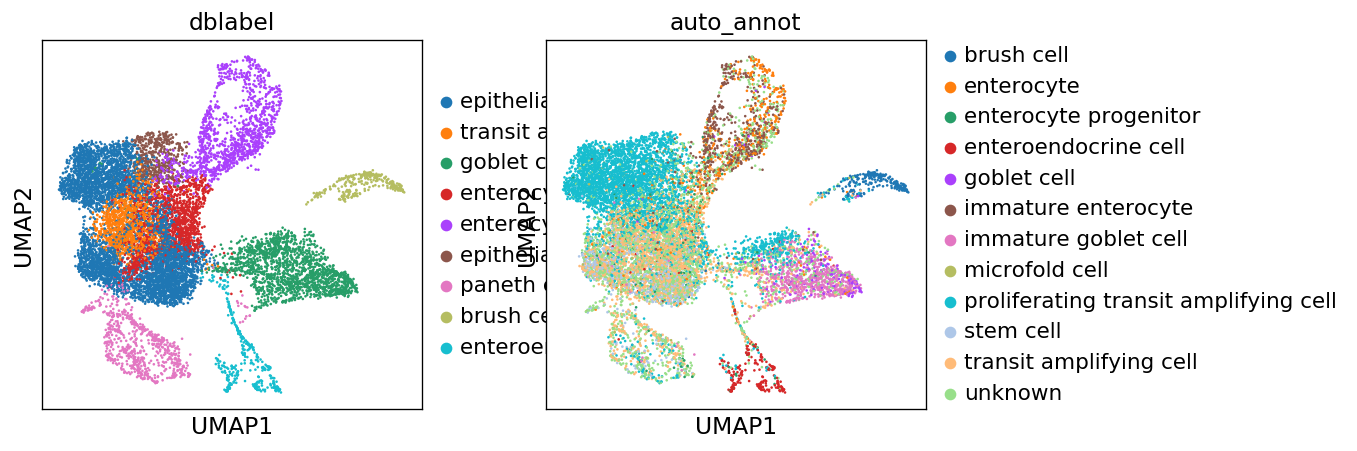

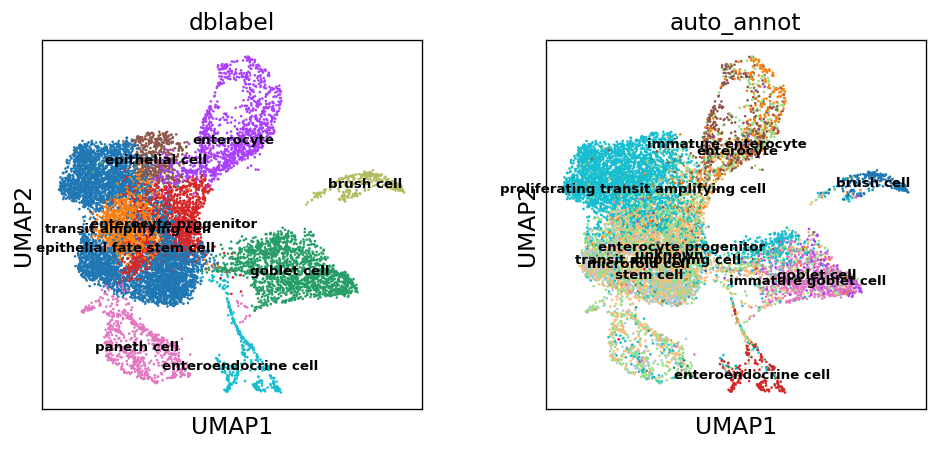

In [24]:
import scanpy as sc
sc.pl.umap(adata_predicted, color=[celltype_test, 'auto_annot'])
sc.pl.umap(adata_predicted, color=[celltype_test, 'auto_annot'], legend_loc='on data', legend_fontsize=8)

In [25]:
adata_train

View of AnnData object with n_obs × n_vars = 46102 × 273 
    obs: 'CELL', 'Cluster', 'Health', 'Location', 'Subject', 'celltype_highlevel', 'nGene', 'nUMI', 'original_name', 'percent_mito', 'n_counts', 'n_genes', 'batch', 'leiden', 'dblabel', 'celltype', 'cluster_celltype', 'Type'
    var: 'ENSEMBL-0', 'SYMBOL', 'n_cells-0', 'total_counts-0', 'frac_reads-0', 'ENSEMBL-1', 'MGI-1', 'n_cells-1', 'total_counts-1', 'frac_reads-1'